# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
%matplotlib inline

#Enable this variable to enable visualization 
display = True #False

## Camera Calibration using chessboard images

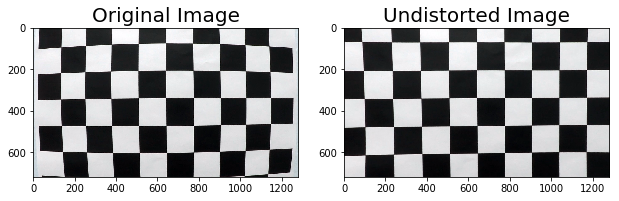

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#Find parameters to undistort the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

if display == True:
    #Test the matrix on one of the images
    img = cv2.imread('./camera_cal/calibration1.jpg')
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective transform Matrix

669 460 268 1049 704 576


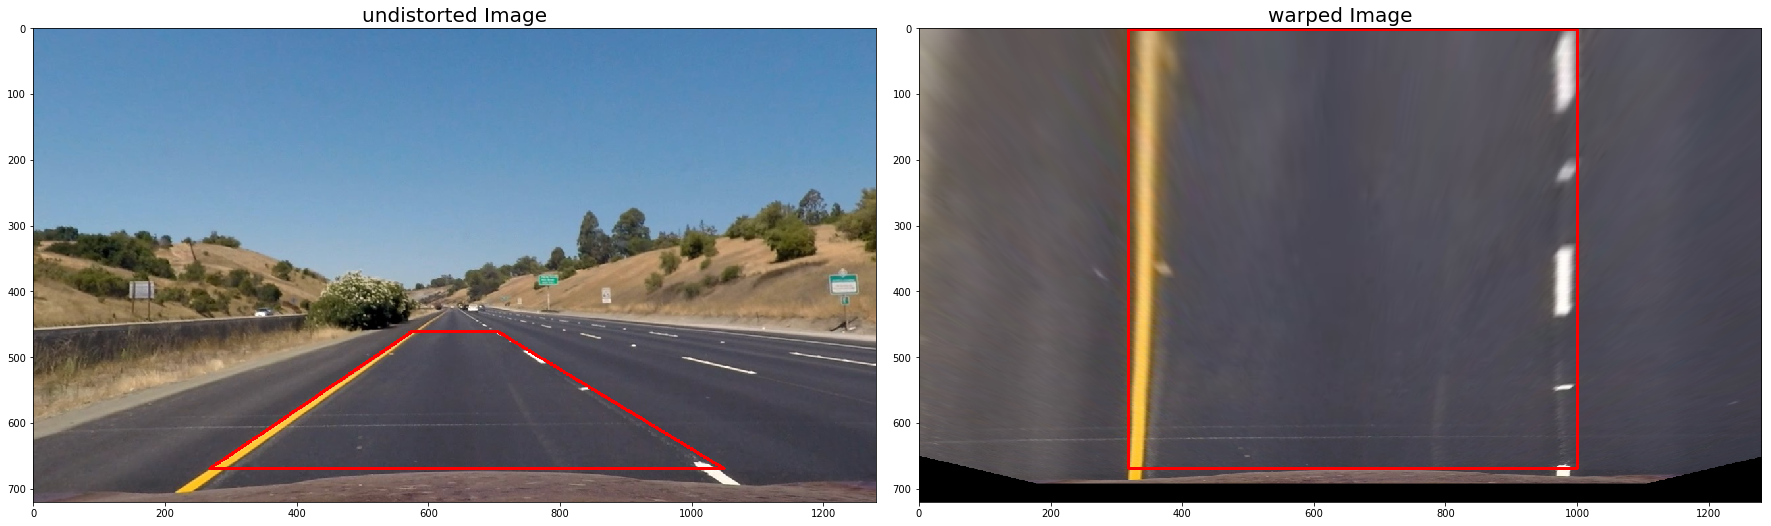

In [4]:
#image = mpimg.imread('test_images/test3.jpg')
image = mpimg.imread('test_images/straight_lines1.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

y_max = int(undistorted.shape[0]*0.93)#670 #undistorted.shape[0] #720
y_min = int(undistorted.shape[0]/2+100)#460 #undistorted.shape[0]/2 + 115 # A little above the mid of the image #475

x_l_b = int(undistorted.shape[1]*0.21) #270 #int(undistorted.shape[1]*0.165)#210
x_r_b = int(undistorted.shape[1]*0.82) #1050 #int(undistorted.shape[1]*0.86) #1100
x_r_t = int(undistorted.shape[1]*0.55)#700 #int(undistorted.shape[1]*9/16) #720
x_l_t = int(undistorted.shape[1]*0.45)#580 #int(undistorted.shape[1]*7/16) #560

print(y_max, y_min, x_l_b, x_r_b, x_r_t, x_l_t)

#Calculate Perspective Transformation Matrix
src = np.float32([[(x_l_b,y_max),(x_r_b,y_max), (x_r_t, y_min),(x_l_t,y_min)]])
dst = np.float32([[(x_l_b+50,y_max),(x_r_b-50,y_max), (x_r_b-50, 1),(x_l_b+50,1)]])
#Transformation Matrix
M = cv2.getPerspectiveTransform(src, dst)
#Inverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

if display == True:
    pts_src = src.astype(int)
    pts_dst = dst.astype(int)
    pts_src = pts_src.reshape((-1,1,2))
    pts_dst = pts_dst.reshape((-1,1,2))

    cv2.polylines(undistorted,[pts_src],True,(255,0,0),4)
    cv2.polylines(warped,[pts_dst],True,(255,0,0),4)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistorted)
    ax1.set_title('undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('warped Image', fontsize=20)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Ideas for Lane Detection Pipeline

- Calibrate the image
- Find Undistorted Images
- Gradient Thresholding with Color and Edges
- Perspective Transform 
- Lane detection using Histograms or Convolution
- Curve Fitting 
- Displaying the final results

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
#Write some fnctions

def get_undistorted_img(img):
    """
    Returns an undistorted image with the parameters calculated in camera calibration using chessboard cell.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)
#"""
def get_thresholded_img(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # TODO
    #Returns a thresholded image with combination of solbelx in lspace and Saturation of HLS color space
    #try combining different approaches
    # TODO
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
#"""    
    
def get_perspective_transformed_image(img):
    """
    Returns an undistorted image using perspective transform matrix.
    """
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)



## Helper functions to find the lines

In [6]:
#class to receive all the lane information

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
print("line class is defined")

line class is defined


In [7]:
def find_curvature_intercept(ploty,fit_val, fit_poly):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, fit_val*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #intercept from center of lane
    intercept = (fit_poly[0]*720**2 + fit_poly[1]*720 + fit_poly[2] - 640)*xm_per_pix
    return curverad, intercept

def find_initial_fit(binary_warped):
    global left_lane 
    global right_lane
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if(leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size ==0 ):
        left_lane.detected = False
        right_lane.detceted = False
        return False 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #### Visualization
    if display == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)

    #Radius of curvature in world frame
    left_curv, left_intcpt = find_curvature_intercept(ploty,left_fitx,left_fit)
    right_curv, right_intcpt = find_curvature_intercept(ploty,right_fitx,right_fit)
    
    #curvature = (left_curv+right_curv)/2
    #car_pstn = (left_intcpt+right_intcpt)/2
    
    left_lane.detected = True  
    left_lane.recent_xfitted = left_fitx
    left_lane.current_fit= left_fit #Current fit polynomials
    left_lane.radius_of_curvature = left_curv
    left_lane.line_base_pos = left_intcpt #distance in meters of vehicle center from the line
    
    right_lane.detected = True  
    right_lane.recent_xfitted = right_fitx
    right_lane.current_fit= right_fit #Current fit polynomials
    right_lane.radius_of_curvature = right_curv
    right_lane.line_base_pos = right_intcpt #distance in meters of vehicle center from the line
    
    #return out_img, left_fit, right_fit, left_fitx, right_fitx,curvature, car_pstn
    return True

   


In [8]:
def find_next_fit(binary_warped):
    global left_lane 
    global right_lane
    global count_bad_frames
    #get the old polyniomials to find margins
    left_fit = left_lane.current_fit
    right_fit =right_lane.current_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    # Check stuff here 
    if(leftx.size==0 or lefty.size ==0):
        return False
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #### Visualization
    if display == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(out_img)

    
    #Radius of curvature in world frame
    left_curv, left_intcpt = find_curvature_intercept(ploty,left_fitx,left_fit)
    right_curv, right_intcpt = find_curvature_intercept(ploty,right_fitx,right_fit)
    
    #curvature = (left_curv+right_curv)/2
    #car_pstn = (left_intcpt+right_intcpt)/2
    curve_good = False
    intercept_good = False
    if(((abs(left_curv/left_lane.radius_of_curvature -1) < 0.6) and 
       (abs(right_curv/right_lane.radius_of_curvature -1) < 0.6)) or
       (left_curv > 6000 or right_curv > 6000)):
     #new curvature within 40% of old
        curve_good = True
    if((abs(left_intcpt/left_lane.line_base_pos-1)<0.15) and 
       (abs(right_intcpt/right_lane.line_base_pos -1)< 0.15)):
        intercept_good = True
        
    #If the intercepts and the curvature are good then only consider the line
    if(curve_good == True and intercept_good == True ):
        left_lane.detected = True  
        left_lane.recent_xfitted = left_fitx
        left_lane.current_fit= left_fit #Current fit polynomials
        left_lane.radius_of_curvature = left_curv
        left_lane.line_base_pos = left_intcpt #distance in meters of vehicle center from the line

        right_lane.detected = True  
        right_lane.recent_xfitted = right_fitx
        right_lane.current_fit= right_fit #Current fit polynomials
        right_lane.radius_of_curvature = right_curv
        right_lane.line_base_pos = right_intcpt #distance in meters of vehicle center from the line
        count_bad_frames = 0
    else:
        count_bad_frames = count_bad_frames+1
    
    #return out_img, left_fit, right_fit, left_fitx, right_fitx, curvature, car_pstn
    return True

#TODO
    #moving average over 10 samples => avg = avg -(avg/10) + new_val/10
    #left_lane.bestx = (left_lane.bestx*0.9 -left_fitx/10) #average x values of the fitted line over the last n iterations
    #left_lane.best_fit = None #AVerage of polynomials
    #left_lane.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
    #left_lane.allx = leftx  #x values for detected line pixels
    #left_lane.ally = lefty #y values for detected line pixels


In [9]:
def get_final_image(warped,undist):
    
    curvature = (left_lane.radius_of_curvature+right_lane.radius_of_curvature)/2
    car_pstn = (left_lane.line_base_pos+right_lane.line_base_pos)/2
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'radius of curvature = {}m'.format(int(curvature)),(180,150), font, 2,(255,0,0),3)
    if car_pstn < 0:
        cv2.putText(result,'car is {:.2f}m left of center'.format(-1 * car_pstn),(180,220), font, 2,(255,0,0),3)
    else:
        cv2.putText(result,'car is {:.2f}m right of center'.format(car_pstn),(180,250), font, 2,(255,0,0),3)
    
    return result
    #plt.imshow(result
    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['test3.jpg',
 'test2.jpg',
 'test4.jpg',
 'test5.jpg',
 'straight_lines2.jpg',
 'test6.jpg',
 'test1.jpg',
 'straight_lines1.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

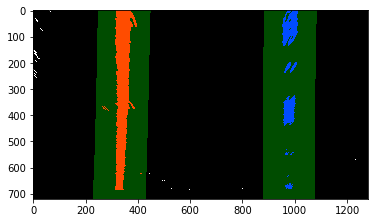

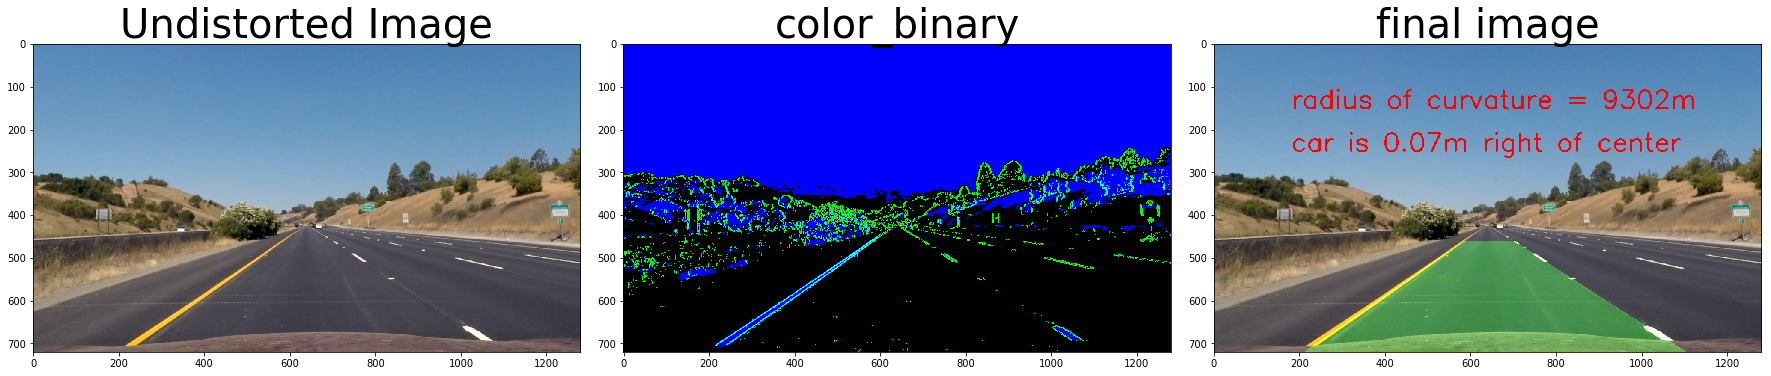

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Read in an image from test images
 

display = True
left_lane =  Line()
right_lane = Line() 
easy_next = False
count_bad_frames = 0
image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/test6.jpg')
undist = get_undistorted_img(image)
color_binary, binary = get_thresholded_img(undist, s_thresh=(80, 255), sx_thresh=(20, 140))
warped = get_perspective_transformed_image(binary)
#"""
#out_img, left_fit, right_fit, left_fitx, right_fitx, curvature, car_pstn = find_initial_fit(warped)
#out_img, left_fit, right_fit, left_fitx, right_fitx, curvature, car_pstn = find_next_fit(warped, left_fit, right_fit)
#get_final_image(warped,undis, left_fitx,right_fitx, curvature, car_pstn)
if(easy_next == False):
    if(find_initial_fit(warped)):
        easy_next = True
        
#Put a counter and see how many we are missing in between
if(easy_next):
    if(find_next_fit(warped)):
        easy_next = True
        
final_img = get_final_image(warped,undist)
                                


#plt.imshow(binary)

#"""

# Plot the result
if display == True:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(undist)
    ax1.set_title('Undistorted Image', fontsize=40)
    ax2.imshow(color_binary)
    ax2.set_title('color_binary', fontsize=40)
    ax3.imshow(final_img)
    ax3.set_title('final image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
first_image = True
left_fit = None
right_fit = None
display = False
left_lane =  Line()
right_lane = Line() 
easy_next = False
count_bad_frames = 0

### Pipeline to process the images from video

In [14]:
def process_image(image):
    global left_fit, right_fit, first_image,count_bad_frames
    undist = get_undistorted_img(image)
    color_binary, binary = get_thresholded_img(undist, s_thresh=(80, 255), sx_thresh=(20, 140))
    warped = get_perspective_transformed_image(binary)
    #calculate complete lines
    if first_image == True:
        if(find_initial_fit(warped)):
            first_image = False
    #Calculate new lines based on old lines
    else:
        find_next_fit(warped)
    
    final_img = get_final_image(warped,undist)
    #If there are bad images in the past lines, calculate new lines and fit the lane 
    if(count_bad_frames >8):
        #print(count_bad_frames)
        count_bad_frames = 0
        first_image = True
    return final_img


Let's try the one with the solid white lane on the right first ...

In [15]:
#Video Processing
#clip1 = VideoFileClip("project_video.mp4")#.subclip(38,43)
#white_output = 'm_out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_output = 'out_project_video.mp4'

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 6min 49s, sys: 10.7 s, total: 7min
Wall time: 2min 53s


In [51]:
#Challenge Video Clip
white_output = 'out_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


100%|██████████| 485/485 [01:07<00:00,  7.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 

CPU times: user 2min 30s, sys: 8.29 s, total: 2min 38s
Wall time: 1min 8s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!